## El código es una ejemplo del uso de los datos compartidos para la generación de una solución para el BBVA Data Challenge 2023

**¡Copia este notebook, ejecútalo y sube la solución!**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/databbva2023/digital.csv
/kaggle/input/databbva2023/Diccionario de datos.xlsx
/kaggle/input/databbva2023/archive/sample_submission.csv
/kaggle/input/databbva2023/archive/balances.csv
/kaggle/input/databbva2023/archive/universe_train.csv
/kaggle/input/databbva2023/archive/movements.csv
/kaggle/input/databbva2023/archive/liabilities.csv
/kaggle/input/databbva2023/archive/universe_test.csv
/kaggle/input/databbva2023/archive/customers.csv


In [3]:
import seaborn as sns

# 1. Universo

In [4]:
path0 = '/kaggle/input/databbva2023/archive/'
universe_train = pd.read_csv(f'{path0}universe_train.csv')
universe_test  = pd.read_csv(f'{path0}universe_test.csv')
universe_test.head()

,ID,period
0,20b427c65c62ee0177adfa300bbf9f93ba2e46c86d5bc7...,period_9
1,4881d4a2146002a02279bedb6f0a844af022b4dd1d8b1b...,period_9
2,28ff12351f215091b54166a09ca44858f3d7f6245f281c...,period_9
3,5cd2c0dc92c1c5ffa83a94f15756cef5c58174e9d8c69a...,period_9
4,ceebdd2bbaafd83d8c205e8071b79da5338e9db94c9509...,period_9


La base de train es la que cuenta con la variable **attrition**, la cual indica el motivo de abandono del segmento objetivo.

In [5]:
universe_train.head()

,ID,attrition,period
0,4d5a33701cb5b30b0b0a924d80de4ae78fbd0b54e2117f...,0,period_5
1,bf7092e5f394d266143dfe90b3fc73eac51f0b0084d7a3...,0,period_5
2,270d8f8f607d19886c50edb7746c3670194134b56d31e2...,0,period_5
3,5e6b7bea5e4911329669f45728d3398ad54dfe11fbb16d...,0,period_5
4,98954adf775b9fce1c9e311a025ec3e0a1c6e90f991ef7...,0,period_5


<Axes: xlabel='attrition', ylabel='count'>

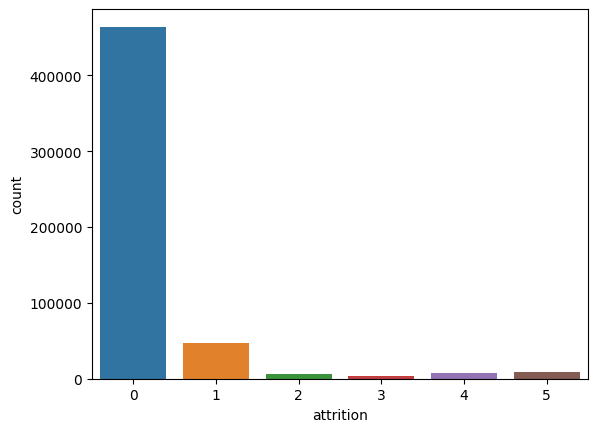

In [6]:
sns.countplot(data = universe_train, x = 'attrition')

Debemos generar las predicciones para el universo de test.

attrition,0,1,2,3,4,5
period,,,,,,
period_1,87.170456,8.519319,1.013623,0.595155,1.321663,1.379783
period_2,86.769048,8.870986,1.106585,0.616804,1.255350,1.381228
period_3,87.309827,8.352997,1.056204,0.607879,1.232612,1.440482
period_4,86.772987,8.644963,1.087769,0.655521,1.220853,1.617906
period_5,86.423273,8.631294,1.196211,0.646719,1.234447,1.868056
period_6,85.153505,9.766998,1.170502,0.665408,1.451599,1.791989


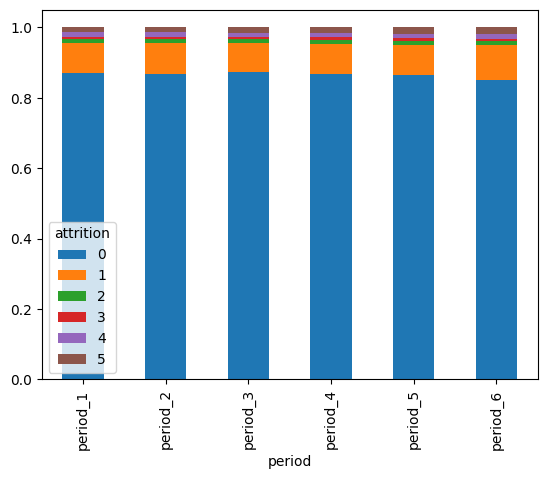

In [10]:
z = universe_train.value_counts(['period', 'attrition']).unstack()
(z/pd.DataFrame(z.sum(axis = 1)).values).plot.bar(stacked = True)
(z/pd.DataFrame(z.sum(axis = 1)).values)*100

# 2. Customer

Contiene datos sociodemográficos; también, de tenencia de productos y ofertas en el banco.

La función siguiente permite leer los datos y transformar las columnas categóricas a numéricas.

In [7]:
def varCustomer():
    # Leer la base
    df_customers = pd.read_csv('/kaggle/input/bbva-data-challenge-2023/archive/customers.csv')
    
    # Columnas binarias
    for col_ in ['product_1', 'product_2', 'product_3', 'product_4', 'ofert_1', 'ofert_2', 'ofert_3']:
        df_customers[col_] = df_customers[col_].apply(lambda x: 1 if x=='Yes' else 0)
        
    # Generar dummies
    df_customers = pd.get_dummies(df_customers, columns = ['type_job', 'bureau_risk'], dtype=int)
    
    return df_customers

### Ejemplo

In [8]:
df_customers = varCustomer()

In [9]:
df_customers.head()

,ID,age,income,time_from_specialized,payroll,product_1,product_2,product_3,product_4,ofert_1,...,type_job_type_7,bureau_risk_category_1,bureau_risk_category_2,bureau_risk_category_3,bureau_risk_category_4,bureau_risk_category_5,bureau_risk_category_6,bureau_risk_category_7,bureau_risk_category_8,bureau_risk_category_9
0,42af3bf64c2c14307361e970e76c9653df78b215838971...,4.2484,4.1259,0.0,4.8095,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,5ab9acd6dc30e0e9361ca53e797b40f68841bd698d0926...,4.6903,3.9570,0.0,0.0000,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,8e40f988dd93417a0a40c32e65386425d891c879fedf4c...,4.1682,4.4640,0.0,0.0000,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,0e48974ce6e81d9e81a8da780521a2f98fb2385dc879df...,3.9651,4.0966,0.0,0.0000,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,0
4,e033c53b4fb230de5da6868503a9e079b289e064d62de4...,3.9576,4.1876,0.0,0.0000,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0


# 3. Balances - RCC

 Contiene los datos de los saldo de crédito del Reporte Crediticio Consolidado.

In [10]:
df_balance = pd.read_csv('/kaggle/input/bbva-data-challenge-2023/archive/balances.csv')

In [11]:
df_balance.head()

,month,ID,type,product,entity,balance_amount,days_default,period
0,11,c844ef92b32ec94baaf565a3d22cfa20fd1544a0f8efab...,type_7,product_2,entity_2,3.4051,5.0,period_5
1,10,c817cb3a37a6b640304e87fafd7cd8569bfffb650a5aa3...,type_7,product_2,entity_1,3.4003,5.0,period_5
2,6,1d1f726d844c5a343cca1bbfd0c2b869559f5910772c5e...,type_7,product_2,entity_5,3.0592,5.0,period_5
3,6,7c77a3fd230db16988cb2e6ca23779c756f86895dfe254...,type_7,product_2,entity_2,2.8013,5.0,period_5
4,11,a8702fb4fbdcb735619d6fbd0a5fed46096cdaba80ea35...,type_7,product_2,entity_2,2.9850,5.0,period_5


Función para la creación de variables de la fuente de balance.

In [12]:
def varRCCPivot(df_balance, historia, pivot, cal = 'mean'):
    """
    df_balance: base de RCC
    historia: cantidad de meses para la historia (máximo 12)
    pivot: columna para el pivot
    cal: cálculo a realizar a las variables numéricas
    """
    # Pivot
    dfRCCVar = pd.pivot_table(df_balance[df_balance['month'] >= 12 - historia + 1], 
                                   index=['ID', 'period'], 
                                   columns=[pivot], 
                                   values=['balance_amount', 'days_default'], 
                                   aggfunc=cal, 
                                   fill_value=0)
    # Renombrar
    dfRCCVar.columns = [x[1]+'_' + x[0] + '_' +cal + '_' + str(historia) for x in dfRCCVar.columns]
    dfRCCVar.reset_index(inplace = True)
    
    return dfRCCVar

### Ejemplo

Cálculo del promedio de los últimos 12 meses de los tipos de crédito.

In [13]:
%%time
dfRccTypeMean12 = varRCCPivot(df_balance, 12, 'type', cal = 'mean')
dfRccTypeMean12.head()

CPU times: user 8.62 s, sys: 652 ms, total: 9.27 s
Wall time: 9.26 s


,ID,period,type_1_balance_amount_mean_12,type_2_balance_amount_mean_12,type_3_balance_amount_mean_12,type_4_balance_amount_mean_12,type_5_balance_amount_mean_12,type_7_balance_amount_mean_12,type_1_days_default_mean_12,type_2_days_default_mean_12,type_3_days_default_mean_12,type_4_days_default_mean_12,type_5_days_default_mean_12,type_7_days_default_mean_12
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.0,0.0,3.190333,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1,00007a4554cd3a350aec583adebe766eb0beef5684f3dd...,period_6,0.0,0.0,3.394012,0.0,0.000000,0.0,0.0,0.0,0.07855,0.0,0.0,0.0
2,000095b7b77ff622b2130f2d4bfa1e8d81f1fc4580a248...,period_5,0.0,0.0,2.385600,0.0,0.000000,0.0,0.0,0.0,5.00000,0.0,0.0,0.0
3,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,0.0,0.0,3.313423,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,0.0,0.0,3.614636,0.0,4.985392,0.0,0.0,0.0,0.20000,0.0,0.0,0.0


In [14]:
%%time
dfRccTypeMean06 = varRCCPivot(df_balance, 6, 'type', cal = 'mean')
dfRccTypeMean06.head()

CPU times: user 5.8 s, sys: 238 ms, total: 6.04 s
Wall time: 6.01 s


,ID,period,type_1_balance_amount_mean_6,type_2_balance_amount_mean_6,type_3_balance_amount_mean_6,type_4_balance_amount_mean_6,type_5_balance_amount_mean_6,type_7_balance_amount_mean_6,type_1_days_default_mean_6,type_2_days_default_mean_6,type_3_days_default_mean_6,type_4_days_default_mean_6,type_5_days_default_mean_6,type_7_days_default_mean_6
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.0,0.0,3.190333,0.000000,0.000000,0.0,0,0.0,0.0000,0.0,0.0,0.0
1,00007a4554cd3a350aec583adebe766eb0beef5684f3dd...,period_6,0.0,0.0,3.577900,0.000000,0.000000,0.0,0,0.0,0.1571,0.0,0.0,0.0
2,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,0.0,0.0,3.289441,0.000000,0.000000,0.0,0,0.0,0.0000,0.0,0.0,0.0
3,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,0.0,0.0,3.514192,0.000000,4.982533,0.0,0,0.0,0.0000,0.0,0.0,0.0
4,0000bf7ea0097a88c482e99ab814e6c4c4495b5a35e520...,period_9,0.0,0.0,3.301070,3.959771,0.000000,0.0,0,0.0,0.0000,0.0,0.0,0.0


In [15]:
df_balance[df_balance.ID == dfRccTypeMean06.ID.iloc[0]]

,month,ID,type,product,entity,balance_amount,days_default,period
2547277,11,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,type_3,product_2,entity_4,3.1754,0.0,period_6
2773383,10,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,type_3,product_2,entity_4,3.2202,0.0,period_6
4109170,12,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,type_3,product_2,entity_4,3.1754,0.0,period_6


In [16]:
dfRccTypeMean06[dfRccTypeMean06.ID == dfRccTypeMean06.ID.iloc[0]]

,ID,period,type_1_balance_amount_mean_6,type_2_balance_amount_mean_6,type_3_balance_amount_mean_6,type_4_balance_amount_mean_6,type_5_balance_amount_mean_6,type_7_balance_amount_mean_6,type_1_days_default_mean_6,type_2_days_default_mean_6,type_3_days_default_mean_6,type_4_days_default_mean_6,type_5_days_default_mean_6,type_7_days_default_mean_6
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.0,0.0,3.190333,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_balance.shape, dfRccTypeMean06.shape, df_balance.ID.nunique() , dfRccTypeMean06.ID.nunique()

((11597785, 8), (493988, 14), 505697, 493988)

In [18]:
5+5

10

### Ejemplo

Cálculo del promedio de los últimos 12 meses por productos.

In [19]:
%%time
!free -h
dfRccProductMean12 = varRCCPivot(df_balance, 12, 'product', cal = 'mean')
!free -h
dfRccProductMean12.head()

              total        used        free      shared  buff/cache   available
Mem:           31Gi       3.2Gi        21Gi       0.0Ki       7.0Gi        27Gi
Swap:            0B          0B          0B
              total        used        free      shared  buff/cache   available
Mem:           31Gi       3.3Gi        21Gi       0.0Ki       7.0Gi        27Gi
Swap:            0B          0B          0B
CPU times: user 9.09 s, sys: 819 ms, total: 9.91 s
Wall time: 10.4 s


,ID,period,product_1_balance_amount_mean_12,product_2_balance_amount_mean_12,product_3_balance_amount_mean_12,product_4_balance_amount_mean_12,product_5_balance_amount_mean_12,product_6_balance_amount_mean_12,product_7_balance_amount_mean_12,product_1_days_default_mean_12,product_2_days_default_mean_12,product_3_days_default_mean_12,product_4_days_default_mean_12,product_5_days_default_mean_12,product_6_days_default_mean_12,product_7_days_default_mean_12
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.000000,3.190333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,00007a4554cd3a350aec583adebe766eb0beef5684f3dd...,period_6,3.611722,2.740880,0.0,0.0,0.0,0.000000,0.0,0.104733,0.0,0.0,0.0,0.0,0.0,0.0
2,000095b7b77ff622b2130f2d4bfa1e8d81f1fc4580a248...,period_5,2.385600,0.000000,0.0,0.0,0.0,0.000000,0.0,5.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,3.313423,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,3.586342,4.293700,0.0,0.0,0.0,4.985392,0.0,0.000000,5.0,0.0,0.0,0.0,0.0,0.0


# 4. Ahorros

Datos de los saldos de ahorro de los clientes.

In [20]:
df_liabilities = pd.read_csv('/kaggle/input/bbva-data-challenge-2023/archive/liabilities.csv')

Función para la creación de variables de la fuente de ahorros.

In [21]:
def varLiabilities(df_liabilities, historia, dict_cal):
    """
    df_liabilities: base de ahorros
    historia: cantidad de meses para la historia (máximo 12)
    dict_cal: diccionario con los cálculos a realizar a las variables numéricas
    """
    
    dfVarLiabilities = df_liabilities[df_liabilities['month'] >= 12 - historia + 1].groupby(['ID', 'period'])\
                        .agg(
                            dict_cal
                        )

    dfVarLiabilities.columns = [ 'pas_'+ x[1]+'_' + x[0] + '_' + str(historia) for x in dfVarLiabilities.columns]

    dfVarLiabilities.reset_index(inplace = True)
    
    return dfVarLiabilities

Diccionario con los cálculos a realizar a las variables numéricas.

In [22]:
liabilities_dict = {
                        'product_1': ['min', 'mean', 'max'],
                        'product_2': ['min', 'mean', 'max'],
                        'month': ['count']
                    }

### Ejemplo

Cálculo de las variables de ahorro en los últimos 6 meses de datos.

In [23]:
%%time
!free -h
dfVarLiabilities6 = varLiabilities(df_liabilities, 6, liabilities_dict)

              total        used        free      shared  buff/cache   available
Mem:           31Gi       4.6Gi        18Gi       0.0Ki       7.8Gi        26Gi
Swap:            0B          0B          0B
CPU times: user 5.88 s, sys: 206 ms, total: 6.09 s
Wall time: 6.35 s


In [24]:
dfVarLiabilities6.head()

,ID,period,pas_min_product_1_6,pas_mean_product_1_6,pas_max_product_1_6,pas_min_product_2_6,pas_mean_product_2_6,pas_max_product_2_6,pas_count_month_6
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.4939,1.949500,3.4815,0.000,0.0000,0.0000,6
1,000043cc1abd7597c99f494cc523ff99a4e0e64e98b128...,period_1,2.7086,3.132133,3.5701,0.073,0.6128,3.1542,6
2,000095b7b77ff622b2130f2d4bfa1e8d81f1fc4580a248...,period_5,3.9865,3.986500,3.9865,0.000,0.0000,0.0000,6
3,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,4.0464,4.099767,4.2115,0.000,0.0000,0.0000,6
4,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,2.6543,2.996833,3.9150,0.000,0.0000,0.0000,6


# 5. Compras

Posee los datos de las compras realizas con la tarjeta del banco en 4 rubros de comercios.

In [25]:
df_movements = pd.read_csv('/kaggle/input/bbva-data-challenge-2023/archive/movements.csv')

In [26]:
df_movements.head()

,period,ID,month,type_1,type_2,type_3,type_4
0,period_9,a66d4bbb5278c8a586e03d81e1be8d3590060d8f37fb8c...,12,0.0000,0.0000,0.0000,3.9437
1,period_9,0d0a4fb4f1c98add65a45cf8882e1d81848502143f4ae2...,1,3.7397,3.3499,0.0000,0.0000
2,period_9,a5b9c4d7ae3dfe5cc1c0ca073b0cb0369e1389bfec5c56...,4,3.6273,3.9726,3.6655,4.4131
3,period_9,8a583965c827c377690b816c90246eaedc499f03a5f25f...,8,3.7855,4.8286,5.0000,4.5094
4,period_9,e53bf4249c7d6d573d532b8b0bad7ffe2fb203a4f00675...,7,2.6077,3.9344,1.3229,3.8061


Función para la creación de variables de compras.

In [27]:
def varMovements(df_movements, historia, dict_cal):
    """
    df_movements: base de compras
    historia: cantidad de meses para la historia (máximo 12)
    dict_cal: diccionario con los cálculos a realizar a las variables numéricas
    """
    dfVarMovements = df_movements[df_movements['month'] >= 12 - historia + 1].groupby(['ID', 'period'])\
                        .agg(
                            dict_cal
                        )

    dfVarMovements.columns = [ 'mov_'+ x[1]+'_' + x[0] + '_' + str(historia) for x in dfVarMovements.columns]

    dfVarMovements.reset_index(inplace = True)
    
    return dfVarMovements

Diccionario con los cálculos a realizar a las variables numéricas.

In [28]:
dic_movements = {
                    'type_1': ['min', 'mean', 'max', 'sum'],
                    'type_2': ['min', 'mean', 'max', 'sum'],
                    'type_3': ['min', 'mean', 'max', 'sum'],
                    'type_4': ['min', 'mean', 'max', 'sum'],
                    'month': ['count']
                }

### Ejemplo

Cálculo de las variables de compras en los últimos 12 meses de datos.

In [29]:
%%time
!free -h
dfVarMovements12 = varMovements(df_movements, 12, dic_movements)

              total        used        free      shared  buff/cache   available
Mem:           31Gi       5.1Gi        18Gi       0.0Ki       8.1Gi        25Gi
Swap:            0B          0B          0B
CPU times: user 4.49 s, sys: 195 ms, total: 4.69 s
Wall time: 4.95 s


In [30]:
dfVarMovements12.head()

,ID,period,mov_min_type_1_12,mov_mean_type_1_12,mov_max_type_1_12,mov_sum_type_1_12,mov_min_type_2_12,mov_mean_type_2_12,mov_max_type_2_12,mov_sum_type_2_12,mov_min_type_3_12,mov_mean_type_3_12,mov_max_type_3_12,mov_sum_type_3_12,mov_min_type_4_12,mov_mean_type_4_12,mov_max_type_4_12,mov_sum_type_4_12,mov_count_month_12
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.0000,1.123000,2.2460,2.2460,0.0,0.0000,0.0000,0.0000,0.0,0.000000,0.0000,0.0000,0.0,1.306700,2.6134,2.6134,2
1,000043cc1abd7597c99f494cc523ff99a4e0e64e98b128...,period_1,0.0000,1.014900,2.0298,2.0298,0.0,0.0000,0.0000,0.0000,0.0,1.711350,3.4227,3.4227,0.0,0.000000,0.0000,0.0000,2
2,00007a4554cd3a350aec583adebe766eb0beef5684f3dd...,period_6,0.0000,0.483617,2.9017,2.9017,0.0,0.0000,0.0000,0.0000,0.0,2.439500,3.4955,14.6370,0.0,2.582583,3.3280,15.4955,6
3,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,3.2138,3.813633,5.0000,11.4409,0.0,1.1299,3.3897,3.3897,0.0,1.340067,4.0202,4.0202,0.0,0.000000,0.0000,0.0000,3
4,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,0.0000,0.574020,2.8701,2.8701,0.0,1.1580,2.9725,5.7900,0.0,0.480020,2.4001,2.4001,0.0,1.102720,2.8355,5.5136,5


# 6. Digital

Posee los datos de la navegación de los clientes en las plataformas digitales del banco.

In [31]:
%%time
!free -h
df_digital = pd.read_csv('/kaggle/input/bbva-data-challenge-2023/digital.csv')

              total        used        free      shared  buff/cache   available
Mem:           31Gi       5.4Gi        17Gi       0.0Ki       8.1Gi        25Gi
Swap:            0B          0B          0B
CPU times: user 11.1 s, sys: 1.29 s, total: 12.4 s
Wall time: 27.1 s


In [32]:
df_digital.head()

,month,ID,dig_1,dig_2,dig_3,dig_4,dig_5,dig_6,dig_7,dig_8,dig_9,dig_10,dig_11,period
0,9,bdc817ca1b6ba0deb42d70bee75e4a4e1a1df5d3c9578c...,0.7329,2.2512,2.9029,3.8084,3.0466,3.2779,0.0000,1.0905,2.2750,0.0000,1.7480,period_9
1,3,7474e915adcf95e11cd85fe1dcb660fee704697ae31f87...,4.2287,4.6974,2.9029,2.7366,2.2263,4.1667,1.9824,1.0905,1.6208,0.0000,0.9672,period_9
2,11,506ff183d63da44a9106db1202b2b9cc53ca680ddca44d...,1.7268,3.8201,2.7194,2.5198,1.4561,4.2153,4.2105,2.1810,3.6138,0.0000,3.3457,period_9
3,4,f59effceec688938accd3f6b5d0684edb2ad484e7bef40...,0.0326,1.6499,1.6981,3.7114,2.9214,3.0473,0.0000,1.0905,2.2750,1.1569,1.7480,period_9
4,3,a0d7da88c4d28b52afba4f4bfa066356042bb0bfe8be8b...,2.1337,4.0528,3.3814,2.9244,1.3486,4.3069,3.6679,1.7284,3.5024,0.0000,3.2128,period_9


Función para la creación de variables digitales.

In [33]:
def varDigital(df_digital, historia, dict_cal):
    """
    df_digital: base digital
    historia: cantidad de meses para la historia (máximo 12)
    dict_cal: diccionario con los cálculos a realizar a las variables numéricas
    """
    dfVarDigital = df_digital[df_digital['month'] >= 12 - historia + 1].groupby(['ID', 'period'])\
                        .agg(
                            dict_cal
                        )

    dfVarDigital.columns = [ 'dig_'+ x[1]+'_' + x[0] + '_' + str(historia) for x in dfVarDigital.columns]

    dfVarDigital.reset_index(inplace = True)
    
    return dfVarDigital

Diccionario con los cálculos a realizar a las variables numéricas.

In [34]:
dic_digital = {
                'dig_1': ['min', 'mean', 'max', 'sum'],
                'dig_2': ['min', 'mean', 'max', 'sum'],
                'dig_3': ['min', 'mean', 'max', 'sum'],
                'dig_4': ['min', 'mean', 'max', 'sum'],
                'dig_5': ['min', 'mean', 'max', 'sum'],
                'dig_6': ['min', 'mean', 'max', 'sum'],
                'dig_7': ['min', 'mean', 'max', 'sum'],
                'dig_8': ['min', 'mean', 'max', 'sum'],
                'dig_9': ['min', 'mean', 'max', 'sum'],
                'dig_10': ['min', 'mean', 'max', 'sum'],
                'dig_11': ['min', 'mean', 'max', 'sum'],
                'month': ['count']
            }

### Ejemplo

Cálculo de las variables digitales en los últimos 12 meses de datos.

In [35]:
%%time
!free -h
dfVarDigital12 = varDigital(df_digital, 12, dic_digital)

              total        used        free      shared  buff/cache   available
Mem:           31Gi       6.7Gi        15Gi       0.0Ki       9.0Gi        24Gi
Swap:            0B          0B          0B
CPU times: user 13.2 s, sys: 278 ms, total: 13.4 s
Wall time: 13.7 s


In [36]:
dfVarDigital12.head()

,ID,period,dig_min_dig_1_12,dig_mean_dig_1_12,dig_max_dig_1_12,dig_sum_dig_1_12,dig_min_dig_2_12,dig_mean_dig_2_12,dig_max_dig_2_12,dig_sum_dig_2_12,...,dig_sum_dig_9_12,dig_min_dig_10_12,dig_mean_dig_10_12,dig_max_dig_10_12,dig_sum_dig_10_12,dig_min_dig_11_12,dig_mean_dig_11_12,dig_max_dig_11_12,dig_sum_dig_11_12,dig_count_month_12
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.0000,1.267000,3.0905,11.4030,1.0457,3.262133,4.2168,29.3592,...,24.1292,0.0000,0.215422,1.9388,1.9388,0.5703,2.228956,3.9845,20.0606,9
1,00007a4554cd3a350aec583adebe766eb0beef5684f3dd...,period_6,1.4158,3.207900,5.0000,6.4158,3.7489,4.374450,5.0000,8.7489,...,2.4473,1.2233,1.581050,1.9388,3.1621,0.0001,0.772600,1.5451,1.5452,2
2,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,1.4274,2.583880,4.1650,25.8388,1.9321,3.770080,5.0000,37.7008,...,13.5465,0.0000,0.775060,1.8656,7.7506,0.0001,0.646870,1.2835,6.4687,10
3,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,1.3679,2.867718,5.0000,31.5449,2.6366,3.518500,4.9355,38.7035,...,22.2467,0.0000,0.701127,3.2312,7.7124,0.0001,1.442000,3.5520,15.8620,11
4,0000bb1dfb27cfb704a54c9b395b443461ff80e5dee265...,period_9,0.0487,0.788273,2.7136,8.6710,1.5163,2.790436,4.9344,30.6948,...,25.8005,0.0000,0.166691,1.8336,1.8336,0.0001,1.832082,4.4049,20.1529,11


# 7. Consolidar

Ahora se va a consolidar todas las fuentes en una matriz que servirá como input al modelo predictivo.

In [37]:
def getMatriz(universo = 'train'):
    
    if universo == 'train':
        df_universo = pd.read_csv('/kaggle/input/bbva-data-challenge-2023/archive/universe_train.csv')
    else:
        df_universo = pd.read_csv('/kaggle/input/bbva-data-challenge-2023/archive/universe_test.csv')
        
    # Consolidar
    
    # Customer
    consolidado = pd.merge(df_universo, varCustomer(), how='left', on = ['ID'])
    
    # RCC
    consolidado = pd.merge(consolidado, varRCCPivot(df_balance, 12, 'type', cal = 'mean'), how='left', on = ['ID', 'period'])
    consolidado = pd.merge(consolidado, varRCCPivot(df_balance, 12, 'product', cal = 'mean'), how='left', on = ['ID', 'period'])
    consolidado = pd.merge(consolidado, varRCCPivot(df_balance, 6, 'entity', cal = 'mean'), how='left', on = ['ID', 'period'])
    ### pueden añadir más variables
    
    # Liabilities
    consolidado = pd.merge(consolidado, varLiabilities(df_liabilities, 6, liabilities_dict), how='left', on = ['ID', 'period'])
    
    # Movements
    consolidado = pd.merge(consolidado, varMovements(df_movements, 12, dic_movements), how='left', on = ['ID', 'period'])
    
    # Digital
    consolidado = pd.merge(consolidado, varDigital(df_digital, 12, dic_digital), how='left', on = ['ID', 'period'])
    
    return consolidado

**Matriz de entrenamiento**

In [38]:
matrix_train = getMatriz(universo = 'train')

**Matriz de evaluación para el envío**

In [39]:
matrix_submit = getMatriz(universo = 'test')

In [40]:
matrix_train.head()

,ID,attrition,period,age,income,time_from_specialized,payroll,product_1,product_2,product_3,...,dig_sum_dig_9_12,dig_min_dig_10_12,dig_mean_dig_10_12,dig_max_dig_10_12,dig_sum_dig_10_12,dig_min_dig_11_12,dig_mean_dig_11_12,dig_max_dig_11_12,dig_sum_dig_11_12,dig_count_month_12
0,4d5a33701cb5b30b0b0a924d80de4ae78fbd0b54e2117f...,0,period_5,3.8498,4.6527,0.000,0.0,0,0,0,...,43.0254,0.0,1.484033,2.9024,17.8084,2.3975,3.321883,3.8992,39.8626,12.0
1,bf7092e5f394d266143dfe90b3fc73eac51f0b0084d7a3...,0,period_5,4.5476,4.2447,4.274,0.0,0,0,0,...,12.7762,0.0,0.000000,0.0000,0.0000,0.0001,0.413200,1.2887,4.5452,11.0
2,270d8f8f607d19886c50edb7746c3670194134b56d31e2...,0,period_5,4.3600,4.2117,0.000,0.0,0,0,0,...,44.7753,0.0,0.894267,1.9812,10.7312,3.0901,3.543000,3.7608,42.5160,12.0
3,5e6b7bea5e4911329669f45728d3398ad54dfe11fbb16d...,0,period_5,4.3914,4.1584,0.000,0.0,0,0,0,...,9.1120,0.0,0.156250,1.2500,1.2500,0.0001,0.386325,0.9748,3.0906,8.0
4,98954adf775b9fce1c9e311a025ec3e0a1c6e90f991ef7...,0,period_5,4.3077,4.3285,0.000,0.0,0,0,0,...,40.3018,0.0,0.208333,1.2500,2.5000,2.3975,3.038483,3.9425,36.4618,12.0


# 8. Seleccionar X e y

El objetivo es generar las bases de train - test para el entrenamiento de datos.

In [41]:
from sklearn.model_selection import train_test_split

Variables que no se considerarán en el modelos

In [42]:
columnas_eliminar = ['ID', 'attrition', 'period']

Seleccionar X e Y

In [43]:
X = matrix_train.drop(columnas_eliminar, axis=1).copy()
y = matrix_train['attrition'].copy()

Partición aleatoria en train y test.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)

# 9. Modelo LightGBM

In [45]:
import lightgbm as lgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

In [46]:
train_data_lgb = lgb.Dataset(X_train, label=y_train)
test_data_lgb = lgb.Dataset(X_test, label=y_test)

Parámetros de lightgbm, para mayor información revisar: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [47]:
params_k = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class': 6,
            'subsample': 0.95,
            'learning_rate': 0.01,
            'max_depth': 5,
            'num_leaves': 100,
            'feature_fraction': 0.9,
            #'max_bin': 100,
            'is_unbalance': True,
            #'boost_from_average': False,
            "random_seed":42,
            'verbose': -1
}

Entrenamiento

In [48]:
%%time
model = lgb.train(params_k,
                       train_data_lgb,
                       valid_sets=[test_data_lgb, train_data_lgb],
                       num_boost_round=1000,
                       early_stopping_rounds=100, verbose_eval=50
                 )

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 0.450983	valid_0's multi_logloss: 0.453794
[100]	training's multi_logloss: 0.421719	valid_0's multi_logloss: 0.426173
[150]	training's multi_logloss: 0.407313	valid_0's multi_logloss: 0.41317
[200]	training's multi_logloss: 0.398631	valid_0's multi_logloss: 0.405849
[250]	training's multi_logloss: 0.392678	valid_0's multi_logloss: 0.401459
[300]	training's multi_logloss: 0.388237	valid_0's multi_logloss: 0.398569
[350]	training's multi_logloss: 0.384809	valid_0's multi_logloss: 0.396595
[400]	training's multi_logloss: 0.381895	valid_0's multi_logloss: 0.395168
[450]	training's multi_logloss: 0.379338	valid_0's multi_logloss: 0.394069
[500]	training's multi_logloss: 0.376909	valid_0's multi_logloss: 0.393157
[550]	training's multi_logloss: 0.374776	valid_0's multi_logloss: 0.392393
[600]	training's multi_logloss: 0.372809	valid_0's multi_logloss: 0.391768
[650]	training's multi_logloss: 0.370905

Gráfica de variables importantes

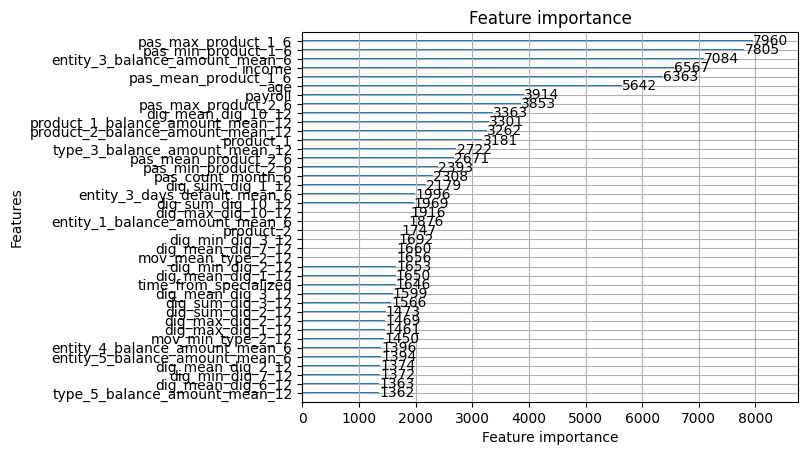

In [51]:
ax = lgb.plot_importance(model, max_num_features=40)
plt.show()

In [59]:
pd.DataFrame(zip( model.feature_name(), model.feature_importance())).sort_values(1,ascending = False).head(50)

,0,1
65,pas_max_product_1_6,7960
63,pas_min_product_1_6,7805
55,entity_3_balance_amount_mean_6,7084
1,income,6567
64,pas_mean_product_1_6,6363
0,age,5642
3,payroll,3914
68,pas_max_product_2_6,3853
124,dig_mean_dig_10_12,3363
39,product_1_balance_amount_mean_12,3301


Predicción de train y test

In [62]:
%%time
prediccion_lgb_test = model.predict(X_test, num_iteration=model.best_iteration)
prediccion_lgb_train = model.predict(X_train, num_iteration=model.best_iteration)

CPU times: user 7min 43s, sys: 661 ms, total: 7min 44s
Wall time: 2min 2s


Medición del F1

In [63]:
%%time
print('train', f1_score(y_train, np.argmax(prediccion_lgb_train, axis=1), average='macro'))
print('test ', f1_score(y_test, np.argmax(prediccion_lgb_test, axis=1), average='macro'))

train 0.24692093347028718
test  0.22100741651659728
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 187 ms


**Predicciones para el envío**

In [53]:
prediccion_lgb_submit = model.predict(matrix_submit[X_train.columns], num_iteration=model.best_iteration)

Recordar el formato del archivo de envío.

In [54]:
submit = matrix_submit[['period', 'ID']].copy()

In [55]:
submit['target'] = np.argmax(prediccion_lgb_submit, axis=1)

In [56]:
submit.head()

,period,ID,target
0,period_9,20b427c65c62ee0177adfa300bbf9f93ba2e46c86d5bc7...,0
1,period_9,4881d4a2146002a02279bedb6f0a844af022b4dd1d8b1b...,0
2,period_9,28ff12351f215091b54166a09ca44858f3d7f6245f281c...,0
3,period_9,5cd2c0dc92c1c5ffa83a94f15756cef5c58174e9d8c69a...,0
4,period_9,ceebdd2bbaafd83d8c205e8071b79da5338e9db94c9509...,0


Archivo para el envío

In [57]:
submit.to_csv('submit_model_bbva.csv', index=False)

In [64]:
X.head()

,age,income,time_from_specialized,payroll,product_1,product_2,product_3,product_4,ofert_1,ofert_2,...,dig_sum_dig_9_12,dig_min_dig_10_12,dig_mean_dig_10_12,dig_max_dig_10_12,dig_sum_dig_10_12,dig_min_dig_11_12,dig_mean_dig_11_12,dig_max_dig_11_12,dig_sum_dig_11_12,dig_count_month_12
0,3.8498,4.6527,0.000,0.0,0,0,0,1,0,0,...,43.0254,0.0,1.484033,2.9024,17.8084,2.3975,3.321883,3.8992,39.8626,12.0
1,4.5476,4.2447,4.274,0.0,0,0,0,1,0,0,...,12.7762,0.0,0.000000,0.0000,0.0000,0.0001,0.413200,1.2887,4.5452,11.0
2,4.3600,4.2117,0.000,0.0,0,0,0,1,0,0,...,44.7753,0.0,0.894267,1.9812,10.7312,3.0901,3.543000,3.7608,42.5160,12.0
3,4.3914,4.1584,0.000,0.0,0,0,0,1,1,1,...,9.1120,0.0,0.156250,1.2500,1.2500,0.0001,0.386325,0.9748,3.0906,8.0
4,4.3077,4.3285,0.000,0.0,0,0,0,1,0,0,...,40.3018,0.0,0.208333,1.2500,2.5000,2.3975,3.038483,3.9425,36.4618,12.0


In [68]:
XX = X.copy()
ii = y==0
XX.loc[ii, 'target'] = 0
XX.loc[~ii, 'target'] = 1
XX

,age,income,time_from_specialized,payroll,product_1,product_2,product_3,product_4,ofert_1,ofert_2,...,dig_min_dig_10_12,dig_mean_dig_10_12,dig_max_dig_10_12,dig_sum_dig_10_12,dig_min_dig_11_12,dig_mean_dig_11_12,dig_max_dig_11_12,dig_sum_dig_11_12,dig_count_month_12,target
0,3.8498,4.6527,0.0000,0.0000,0,0,0,1,0,0,...,0.0,1.484033,2.9024,17.8084,2.3975,3.321883,3.8992,39.8626,12.0,0.0
1,4.5476,4.2447,4.2740,0.0000,0,0,0,1,0,0,...,0.0,0.000000,0.0000,0.0000,0.0001,0.413200,1.2887,4.5452,11.0,0.0
2,4.3600,4.2117,0.0000,0.0000,0,0,0,1,0,0,...,0.0,0.894267,1.9812,10.7312,3.0901,3.543000,3.7608,42.5160,12.0,0.0
3,4.3914,4.1584,0.0000,0.0000,0,0,0,1,1,1,...,0.0,0.156250,1.2500,1.2500,0.0001,0.386325,0.9748,3.0906,8.0,0.0
4,4.3077,4.3285,0.0000,0.0000,0,0,0,1,0,0,...,0.0,0.208333,1.2500,2.5000,2.3975,3.038483,3.9425,36.4618,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535938,4.7952,4.5079,0.0000,4.4682,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
535939,4.0956,4.6016,4.1384,4.6311,0,0,0,1,1,1,...,0.0,0.361325,1.4453,4.3359,2.5198,2.944883,3.3723,35.3386,12.0,0.0
535940,3.6104,4.0808,0.0000,3.6520,0,0,0,1,0,0,...,0.0,0.552225,2.2908,6.6267,3.3723,4.642900,5.0000,55.7148,12.0,1.0
535941,4.0516,4.5814,3.9744,4.5762,0,0,0,1,1,1,...,0.0,0.000000,0.0000,0.0000,2.2634,2.992500,3.7114,35.9100,12.0,0.0


In [76]:
%%time
from scipy import stats
import gc
def KVS_TEST(dfX, y, pv0 = .005):
    #Kolmogorov-Smirnov TEST """
    names = []
    PV = []
    ST = []
    #Z = dfX.copy()
    for n in dfX.columns:
        #print(n)
        X0 =  pd.to_numeric(dfX[n], errors='coerce').astype(float) #dfX[n] ; pd.to_numeric(df[c], errors='coerce')
        z0 = X0[y==0].values
        z1 = X0[y==1].values
        st, pv = stats.ks_2samp(z0, z1)
        if pv <pv0:
            names.append(n)
            PV.append(pv)
            ST.append(st)
    gc.collect()
    return names, np.array(PV), np.array(ST)

col_cont = list( XX.columns[0:-1] )
names, pv, st = KVS_TEST(XX[col_cont] , XX.target,  pv0 = 0.0005)
print(len(names), len(col_cont))

colf = names #+ col_cat
print (len(colf) )

127 132
127
CPU times: user 16.2 s, sys: 168 ms, total: 16.3 s
Wall time: 16.3 s


<Axes: xlabel='dig_count_month_12', ylabel='Density'>

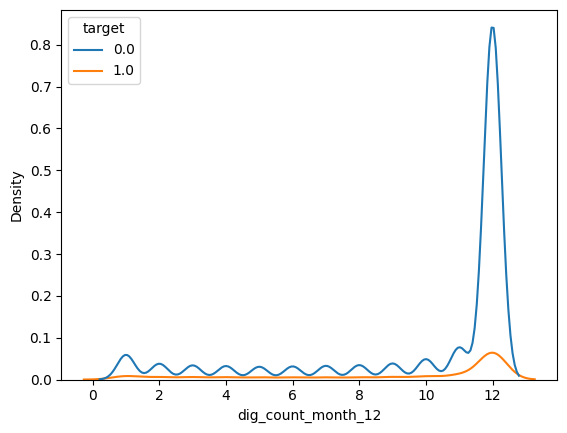

In [78]:
sns.kdeplot(data=XX, x="dig_count_month_12", hue="target")

<Axes: xlabel='dig_max_dig_10_12', ylabel='Density'>

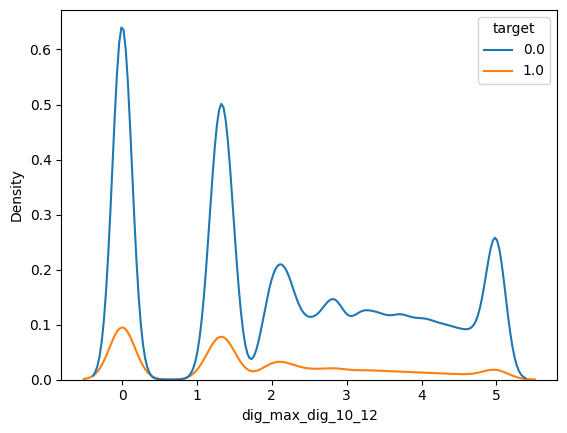

In [79]:
sns.kdeplot(data=XX, x="dig_max_dig_10_12", hue="target")


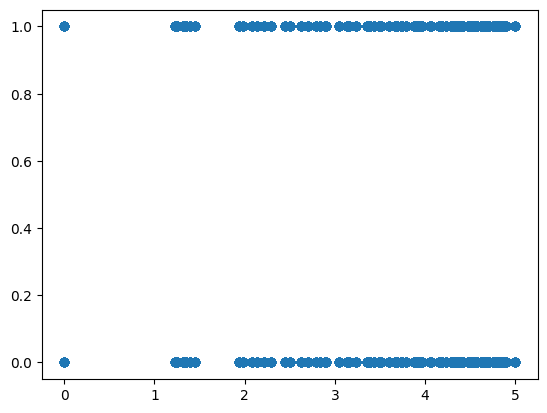

In [80]:
plt.scatter(XX.dig_max_dig_10_12, XX.target, alpha = .1)

target
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: dig_count_month_12, dtype: object

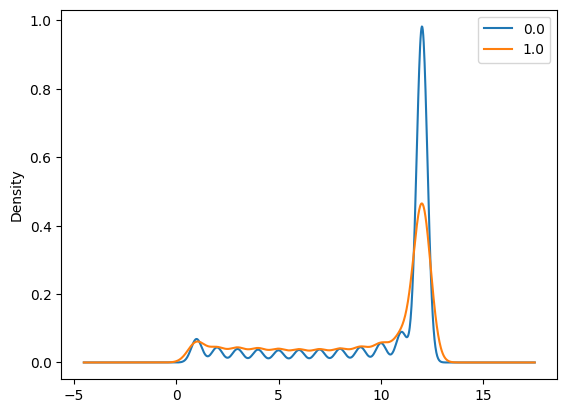

In [82]:
XX.groupby('target')['dig_count_month_12'].plot(kind='density', legend=True)

In [87]:
XX.groupby('target')['dig_max_dig_10_12'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,366863.0,2.163046,1.679042,0.0,1.2233,1.9812,3.5092,5.0
1.0,58889.0,1.772900,1.536798,0.0,0.0000,1.3947,2.8403,5.0


In [86]:
(XX.isna().sum()/XX.shape[0]).sort_values()

age                               0.000000
bureau_risk_category_9            0.000000
bureau_risk_category_8            0.000000
bureau_risk_category_7            0.000000
bureau_risk_category_6            0.000000
                                    ...   
entity_5_balance_amount_mean_6    0.394632
entity_4_balance_amount_mean_6    0.394632
entity_3_balance_amount_mean_6    0.394632
entity_1_balance_amount_mean_6    0.394632
entity_1_days_default_mean_6      0.394632
Length: 133, dtype: float64